In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from pandas.api.types import is_numeric_dtype
from sklearn.linear_model import LinearRegression
from pprint import pprint
from sklearn.metrics import mean_squared_error


# Deliverables
1. Research Question
    - Can we predict the S&P price over the next 10 days using financial indicators?
3. Hypothesis
    - Null: There are no correlations
    - Alternative: There are correlations

In [2]:
bond_yield_df = pd.read_csv("Bond yield.csv")
cpi_df = pd.read_csv("Consumer price index.csv")
dj_df = pd.read_csv("Dow Jones.csv")
usd_eur_df = pd.read_csv("USD_EUR.csv")
usd_jpy_df = pd.read_csv("USD_JPY.csv")
gdp_df = pd.read_csv("GDP.csv")
national_hpi_df = pd.read_csv("National home price index.csv")
sp_df = pd.read_csv("S&P Price.csv")

dfs = [bond_yield_df, cpi_df, dj_df, usd_eur_df, usd_jpy_df, gdp_df, national_hpi_df, sp_df]

In [3]:
for i in range(len(dfs)):
    dfs[i].columns.values[0] = 'date'
    dfs[i] = dfs[i].drop_duplicates(subset="date", keep="first") 
    
    dfs[i].set_index('date', inplace=True)
    dfs[i].index = pd.to_datetime(dfs[i].index, errors="coerce").normalize()

    dfs[i] = dfs[i][~dfs[i].index.duplicated(keep="first")]

In [4]:
merged_df = pd.concat(dfs, axis=1)

In [5]:
df = merged_df[['Value', 'DJIA', 'GDP', 'DGS10', 'CSUSHPINSA', 'CPIAUCSL', 'EURO', 'JPY']]
df.columns = ['SP_price','dow_jones','gdp','bond_yield','home_price_index','consumer_price_index','eur','jpy']
for col in df.columns:
    print(col)
    # df[col] = pd.to_numeric(df[col])
df.reset_index(inplace=True)
full_date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
df.set_index("date", inplace=True) 
df = df.reindex(full_date_range)
df.index.name = "date"

df= df.ffill()

df = df[df.index >= '1987-01-01']


SP_price
dow_jones
gdp
bond_yield
home_price_index
consumer_price_index
eur
jpy


In [6]:
def insert_mirrored_rows(df, num_rows=30):
    """
    Insert chronologically mirrored data point at head and tail of df
    """
    df = df.copy()
    mirrored_rows_head = df.iloc[:num_rows].copy()
    mirrored_rows_head = mirrored_rows_head.iloc[::-1].reset_index(drop=True)

    mirrored_rows_tail = df.iloc[-num_rows:].copy()
    mirrored_rows_tail = mirrored_rows_tail.iloc[::-1].reset_index(drop=True)

    df_extended = pd.concat([mirrored_rows_head, df, mirrored_rows_tail], ignore_index=True)
    
    return df_extended

In [7]:
df['SP_price_ln'] = np.log(df['SP_price'])
df['dow_jones'] = pd.to_numeric(df['dow_jones'].str.replace(',', '', regex=True))

extended_df = insert_mirrored_rows(df['SP_price'].copy(), 200)


SP_price                float64
dow_jones               float64
gdp                     float64
bond_yield              float64
home_price_index        float64
consumer_price_index    float64
eur                     float64
jpy                     float64
SP_price_ln             float64
dtype: object

In [8]:
ma30_df = df.rolling(window=30).mean().reset_index().iloc[30:-30].reset_index(drop=True)
ma100_df = df.rolling(window=100).mean().reset_index().iloc[100:-100].reset_index(drop=True)
ma200_df = df.rolling(window=200).mean().reset_index().iloc[200:-200].reset_index(drop=True)
df['SP_MA_30'] = df['SP_price'].rolling(window=30).mean()
df['SP_MA_100'] = df['SP_price'].rolling(window=100).mean()
df['SP_MA_200'] = df['SP_price'].rolling(window=200).mean()


In [ ]:
df.reset_index(inplace=True) 
df_first_of_month = df[df['date'].dt.day == 1]

## Add timeseries features
- For each daily feature, get the last 10 days for that feature

In [11]:
df['dow_jones_ln'] = np.log(df['dow_jones'])
df['gdp_ln'] = np.log(df['gdp'])
df['home_price_index_ln'] = np.log(df['home_price_index'])
df['bond_yield_ln'] = np.log(df['bond_yield'])


In [12]:
daily_features = ["SP_price_ln", "dow_jones_ln", "gdp_ln", "eur", "jpy", "home_price_index_ln", "consumer_price_index", "bond_yield_ln"]

#################
lookback = 20
forecast = 5
#################
# Store all new columns in a dictionary first
new_cols = {}

# Forecast columns (shift forward)
for f in daily_features:
    new_cols[f + f"+{forecast}"] = df[f].shift(-forecast)

# Lookback columns (shift backward)
for f in daily_features:
    for i in range(1, lookback + 1):
        new_cols[f + f"-{i}"] = df[f].shift(i)

# Combine all at once using pd.concat
df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)

# df.iloc[35177:35187]
df_with_wknd = df.copy()
df = df[df['date'].dt.weekday < 5].reset_index(drop=True)

(10002, 185)

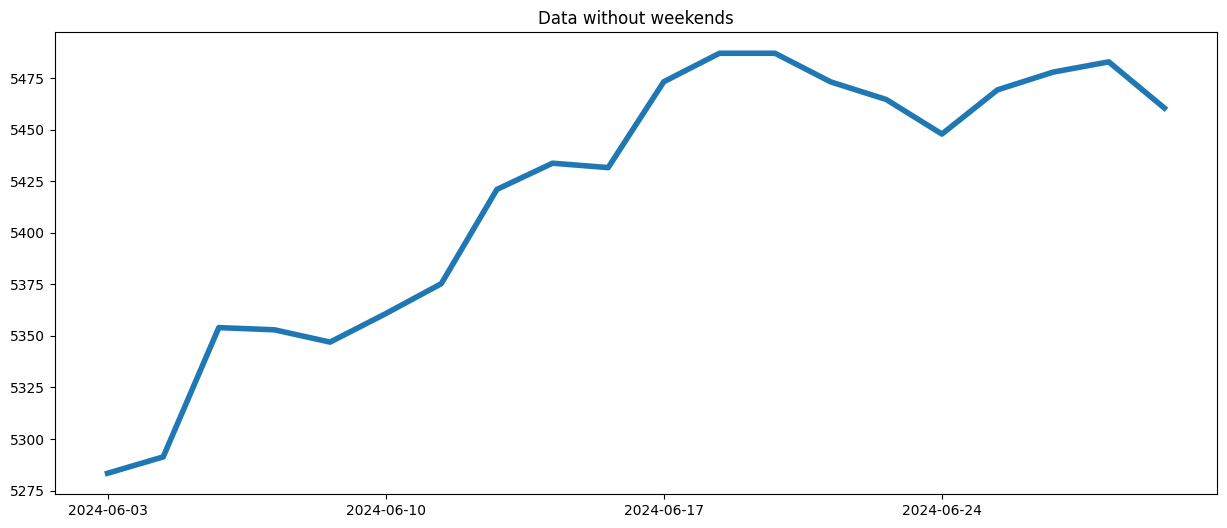

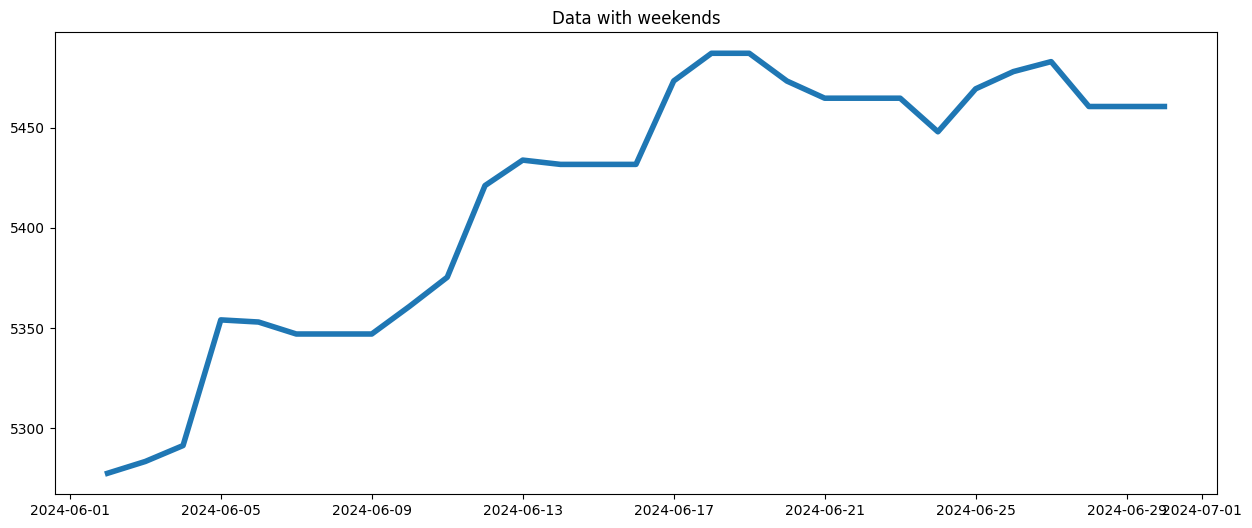

In [14]:
start, end = ('2024-6-1','2024-7-1')
df_with_wknd_event = df_with_wknd[(df_with_wknd['date'] > pd.to_datetime(start)) & (df_with_wknd['date'] < pd.to_datetime(end))]
df_event = df[(df['date'] > pd.to_datetime(start)) & (df['date'] < pd.to_datetime(end))]

plt.figure(figsize=(15,6))
plt.plot(df_event.index, df_event['SP_price'], linewidth=4)
plt.title('Data without weekends')
plt.xticks(ticks=df_event.index[::5], labels=df_event['date'].dt.strftime('%Y-%m-%d')[::5])
plt.show()

plt.figure(figsize = (15,6))
plt.plot(df_with_wknd_event['date'],df_with_wknd_event['SP_price'], linewidth=4)
plt.title('Data with weekends')
plt.show()

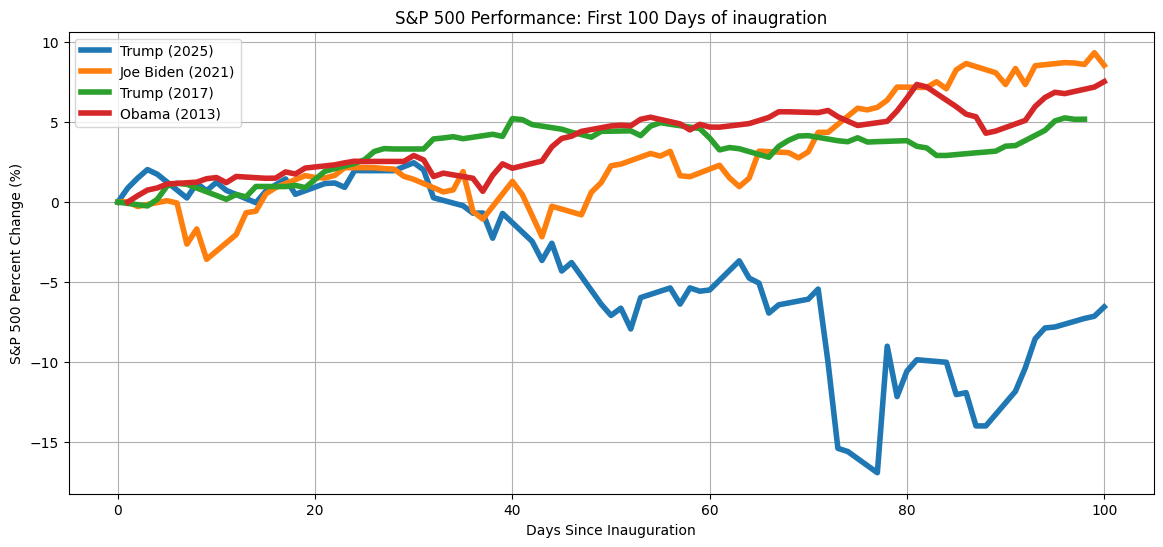

In [15]:
inaugurations = {
    'Trump (2025)': pd.Timestamp('2025-01-20'), 
    'Joe Biden (2021)': pd.Timestamp('2021-01-20'),
    'Trump (2017)': pd.Timestamp('2017-01-20'),
    'Obama (2013)': pd.Timestamp('2013-01-20')
}

plt.figure(figsize=(14, 6))
for president, start_date in inaugurations.items():
    end_date = start_date + pd.DateOffset(days=100)
    
    mask = (df['date'] >= start_date) & (df['date'] <= end_date)
    period_df = df.loc[mask].copy()
    
    if not period_df.empty:
        period_df['Days Since Inauguration'] = (period_df['date'] - start_date).dt.days
        
        start_price = period_df.iloc[0]['SP_price']
        
        period_df['Percent Change'] = ((period_df['SP_price'] - start_price) / start_price) * 100
        
        plt.plot(
            period_df['Days Since Inauguration'],
            period_df['Percent Change'],
            label=president,
            linewidth=4
        )
plt.xlabel('Days Since Inauguration')
plt.ylabel('S&P 500 Percent Change (%)')
plt.title('S&P 500 Performance: First 100 Days of inaugration')
plt.grid(True)
plt.legend()
plt.show()
